In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as r

# Testing strategies for an infection test at low infection rates

Inspired by this [blog post](http://www.bureauwo.com/uncategorized/te-weinig-tests-gebruik-ze-slimmer/) (in Dutch) I decided to look at simple versions of testing strategies, in a rather quick-and-dirty way. The idea is that if being infected (testing positive) is rare, you could start out by testing in a large group. If there's no infection in that whole group you're done with one test for all of them! If there, on the other hand, *is* an infection, you can cut the group in two and do the same for both halves. You can continue this process until you have isolated the few individuals that are infected.

It is clear, though, that many people get tested more than once and especially the infected people are getting tested quite a number of times. Therefore, this is only going to help if a relatively low number of people is infected. Here, I look at the numbers with very simple simulations.

I create batches of people. Randomly, some fraction gets assigned "infected", the rest is "healthy". Then I start the test, which I assume to be perfect (i.e. every infected person gets detected and there are no false positives). For different infection rates (true percentage overall that is infected), and for different original batch sizes (the size of the group that initially gets tested) I study how many tests are needed to isolate every single infected person.

Normally, by testing people one by one, you would need as many tests as people to do this. To investigate the gain by group testing, I divide the number of tests the simulation needs by this total number. The total number of people that can be tested is a factor *gain* higher, given a maximum number of tests, like we have available in the Netherlands.

Here goes!

In [3]:
def n_tests_necessary(infections, n_tests=0):
    """Determine the number of tests necessary
    assuming that we start with the whole group
    and consequently cut intwo equally large groups
    if there is an infection.
    
    Returns total number of tests used to find every
    single infected person."""
    
    n_tests +=1
    
    # Cut the group in two if necessary and call this same
    # function on both subgroups, tracking number of tests
    if infections.sum() >= 1 and len(infections) > 1:
        cut = int(len(infections)/2) 
        n_tests = n_tests_necessary(infections[:cut], n_tests=n_tests)
        n_tests = n_tests_necessary(infections[cut:], n_tests=n_tests)
    
    return n_tests



With the functionality above, I set up a test for the whole of the Netherlands (let's pretend we can in fact test everybody, how cool would that be?!) below. I test in groups of 256 people (conveniently a power of two, but this is not at all necessary!) and assume an overall infection rate of 1%. Let's see how much we can gain.

In [2]:
# Parameters
n_per_batch = 2**8
n_batches = int(17e6/n_per_batch) # Do the whole of the Netherlands
# n_batches = 1000                  # Test fewer
n_people = n_batches * n_per_batch
fraction_inf = 0.01

# Set up population
r.seed(42)
people = np.zeros(n_people) + r.random(size=n_people)
infected = (people < fraction_inf).reshape(n_batches, -1)

In [4]:
nt = np.zeros(n_batches)
for batch in range(n_batches):
    nt[batch] = n_tests_necessary(infected[batch])
print(f"{int(nt.sum())} tests necessary to test {n_people} people in batches of {n_per_batch} with a infected fraction of {fraction_inf}.")
print(f"Factor in lowering the number of tests: {n_people/nt.sum():3.2f}")

2239436 tests necessary to test 16999936 people in batches of 256 with a infected fraction of 0.01.
Factor in lowering the number of tests: 7.59


Almost a factor of 8! Not too bad. Apparently we can easily test a factor of 8 more people with the same amount of tests than we do now. That is, given that my assumptions weren't too far off (and I believe they aren't too crazy).

Now let's see how that gain factor depends on the overall infected fraction and the batch size we use. The results are shown in the graph below.

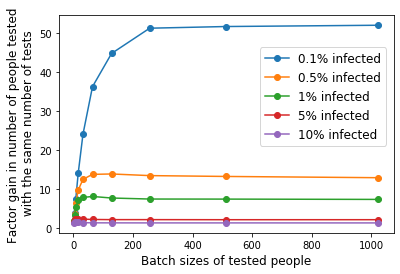

In [5]:
labels = ["0.1% infected", "0.5% infected", "1% infected", "5% infected", "10% infected"]
factors = np.zeros(shape=(len(labels), 13))

n_batches = 10000 # Do the whole of the Netherlands

r.seed(42)

batchnumbers = 2**np.arange(1, 11)
for ifr, fraction_inf in enumerate([.001, .005, .01, .05, .1]):
    for iba, n_per_batch in enumerate(batchnumbers):
        n_people = n_batches * n_per_batch

        # Set up population
        people = np.zeros(n_people) + r.random(size=n_people)
        infected = (people < fraction_inf).reshape(n_batches, -1)
        nt = np.array([n_tests_necessary(infected[batch]) for batch in range(n_batches)])
        factors[ifr, iba] = (n_people/nt.sum())
    
    plt.plot(batchnumbers[:10], factors[ifr][:10], 'o-', label=labels[ifr])
    

plt.legend(loc=(.6, .4), fontsize=12)
plt.xlabel('Batch sizes of tested people', fontsize=12)
plt.ylabel('Factor gain in number of people tested\n with the same number of tests', fontsize=12);
plt.savefig('COVID_gainfactors.png', dpi=400)

As can be seen, going through the hassle of group testing is not worth it if the true infected fraction is well above a percent. If it is below, the gain can be high, and ideal batch sizes are around 50 to 100 people or so. If we are lucky, and significantly less than a percent of people is infected, gains can be more than an order of magnitude, which would be awesome.

Obviously, group testing comes at a price as well. First of all, people need to be tested more than once in many cases (which requires test results to come in relatively quickly). Also, there's administrative overhead, as we need to keep track of which batch you were in to see if further testing is necessary. Last, but certainly not least, it needs to be possible to test many people at once without them infecting each other. In the current standard setup, this is tricky, but given that testing is basically getting some cotton swab in a fluid, I'm confident that we could make that work if we want!

If we are unlucky, and far more than a percent of people are infected, different strategies are needed to combine several people in a test. As always, [wikipedia](https://en.wikipedia.org/wiki/Group_testing) is a great source of information for these. 

And the real caveat... realistic tests aren't perfect...